## Code builds off of StreamflowValidation_GRDC 

Goal is to read in GRDC data along a series of large rivers (31, since there are no observations along the Dniepr River). Most of this data is at a daily resolution, but at 62 stations only monthly data was available. <br>
The GRDC observational data is then cmopared to CaMa-based streamflow at a nearby gridcell. A few approachs can be taken for comparison - either choosing the nearest single gridcell to a single GRDC station, taking the average of all CaMa gridcells within some range (i.e., 1/2 degree) of a single GRDC station, or averaging all GRDC stations along a river for comparison to basin averaged streamflow. 
<br><br>
One of the challenges though, will be identifying stations as 'upstream' (which is done in the hope of limiting human influence on observed streamflow)

*Basins are defined as follows:*
<font color=green>
% Key: <br>
   1.......Yukon <br>
   2.......Mackenzie<br>
   3.......Columbia<br>
   4.......Nelson<br>
   5.......Mississippi<br>
   6.......St-Lawrence<br>
   7.......Rhine<br>
   8.......Danube<br>
   9.......Dniepr<br>
   10......Volga<br>
   11......Ob<br>
   12......Yenisei<br>
   13......Lena<br>
   14......Amur<br>
   15......Orinoco<br>
   16......Parana<br>
   17......Amazonas<br>
   18......Niger<br>
   19......Congo<br>
   20......Nile<br>
   21......Zambezi<br>
   22......Tigris & Euphrates<br>
   23......Indus<br>
   24......Ganges & Brahmaputra<br>
   25......Mekong<br>
   26......Huang-he<br>
   27......Yangtze<br>
   28......Murray & Darling<br>
   29......Don<br>
   30......Fraser<br>
   31......Tocantins<br>
   32......Vuoski & Neva<br>
    </font>

In [1]:
import scipy as scipy
import numpy as np
import scipy.io as sio
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util
import time 
import xarray as xr
import pickle 
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
from netCDF4 import Dataset

#Note - removed scipy.stats library

/home/mdfowler/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mdfowler/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mdfowler/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#Define list of basin names based on key (used in plotting)
basinNames = ['Yukon','Mackenzie','Columbia','Nelson','Mississippi','St-Lawrence','Rhine','Danube','Dniepr','Volga','Ob','Yenisei',\
'Lena','Amur','Orinoco','Parana','Amazonas','Niger','Congo','Nile','Zambezi','Tigris & Euphrates','Indus',\
'Ganges & Brahmaputra','Mekong','Huang-he','Yangtze','Murray & Darling','Don','Fraser','Tocantins','Vuoski & Neva']

#Define time array for plotting too
days = np.arange(365)+1

#Beginning julian days for each month
startMon = [0, 31,59, 90,120,151,181,212,243,273,304,334]
daysPerMonth = [31,28,31,30,31,30,31,31,30,31,30,31]
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


## Compute annual average of CaMa data at each gridcell

In [3]:
# --- Read in data first --- #

#Get dimensions from a single file (same will be used for all files)
file1 = 'fldare1161.nc'
dat   = Dataset(file1)
lat   = dat.variables['lat'][:] 
lon   = dat.variables['lon'][:] 

#Read in bsin ID identifiers from Matlab file 
basinData = sio.loadmat('BasinMask.mat')
basinMask = basinData['BasinMask']

#Read in CaMa gridcell areas
matData = sio.loadmat('CaMa_gridAreas.mat')
area    = matData['area']

## Read in daily data... 

#Read indices for subsetted data 
lonFile = open("lonIndices_subsetKey.txt","r")
latFile = open("latIndices_subsetKey.txt","r")

#Compile list of lons and lats corresponding to CaMa streamflow records
lonSubset=[]
for line in lonFile.readlines():
    lonSubset.append(float(line))  

latSubset=[]
for line in latFile.readlines():
    latSubset.append(float(line))

#Set filepaths for daily data
ctrlFile = 'Control_outflow_subset.nc'
fullFile = 'Full_outflow_subset.nc'
physFile = 'Physiology_outflow_subset.nc'
radFile  = 'Radiation_outflow_subset.nc'

#Read in outflow data  
fCtrl = xr.open_dataset(ctrlFile,decode_times=False)
fFull = xr.open_dataset(fullFile,decode_times=False)
fPhys = xr.open_dataset(physFile,decode_times=False)
fRad  = xr.open_dataset(radFile,decode_times=False)

outflwCtrl = fCtrl.outflow
outflwFull = fFull.outflow
outflwPhys = fPhys.outflow
outflwRad  = fRad.outflow


In [5]:
# # --- Separate CaMa data into individual basins --- #

# # Define empty arrays to store basin-specific data in 
# annCtrl = np.full([len(basinNames),30,365],np.nan)
# annFull = np.full([len(basinNames),30,365],np.nan)
# annPhys = np.full([len(basinNames),30,365],np.nan)
# annRad  = np.full([len(basinNames),30,365],np.nan)
# avgCtrl = np.full([len(basinNames),365],np.nan)
# avgFull = np.full([len(basinNames),365],np.nan)
# avgPhys = np.full([len(basinNames),365],np.nan)
# avgRad = np.full([len(basinNames),365],np.nan)
# avgLat = np.full([len(basinNames)],np.nan)
# avgLon = np.full([len(basinNames)],np.nan)
# basinArea_CaMa = np.full([len(basinNames)],np.nan)

# # Loop over basins 
# for iBasin in range(len(basinNames)):
#     basinChoice = iBasin+1
    
#     #Define empty arrays and variable to count number of obs in basin
#     iSubset  = []
#     gridArea = []
#     basinObs = 0
    
#     #Loop over every location in the subset of daily data 
#     for iLoc in range(len(lonSubset)): 
#         ilon = int(lonSubset[iLoc])
#         ilat = int(latSubset[iLoc])

#         #Check if this location is part of basin being analyzed
#         if (basinMask[ilon,ilat]==basinChoice):
#             iSubset = np.append(iSubset,iLoc)               #Save iLoc (index of subset) if in basin
#             gridArea = np.append(gridArea,area[ilon,ilat])  #Save area of each valid gridcell   
#             basinObs = basinObs+1

#     iSubset=np.asarray(iSubset,dtype=int)  
#     print(basinObs, ' points used in the', basinNames[basinChoice-1])

#     #Isolate just the data in specified basin for further analysis 
#     basinLon  = np.take(lonSubset,iSubset)
#     basinLat  = np.take(latSubset,iSubset)
#     basinCtrl = np.take(outflwCtrl.values,iSubset,axis=0)
#     basinFull = np.take(outflwFull.values,iSubset,axis=0)
#     basinPhys = np.take(outflwPhys.values,iSubset,axis=0)
#     basinRad  = np.take(outflwRad.values,iSubset,axis=0)
#     avgLat[iBasin] = np.nanmean(lat[np.asarray(basinLat,dtype=int)])
#     avgLon[iBasin] = np.nanmean(lon[np.asarray(basinLon,dtype=int)])
#     basinArea_CaMa[iBasin] = np.nansum(gridArea*1e6) #Convert from km^2 to m^2 
#     print('Basin isolated')

#     #-------------------------------------------------------------------------------

#     ## Create annual climatology for the basin ##

#     # Area weighted averages 
#     wgtAvgCtrl = np.full([30*365],np.nan)
#     wgtAvgFull = np.full([30*365],np.nan)
#     wgtAvgPhys = np.full([30*365],np.nan)
#     wgtAvgRad  = np.full([30*365],np.nan)

#     for iDay in range(30*365): 
#         wgtAvgCtrl[iDay] = np.nansum(gridArea*basinCtrl[:,iDay])/np.nansum(gridArea)
#         wgtAvgFull[iDay] = np.nansum(gridArea*basinFull[:,iDay])/np.nansum(gridArea)
#         wgtAvgPhys[iDay] = np.nansum(gridArea*basinPhys[:,iDay])/np.nansum(gridArea)
#         wgtAvgRad[iDay]  = np.nansum(gridArea*basinRad[:,iDay])/np.nansum(gridArea)
#     print('Area weighting completed')

#     # Split into 30 years to get at composite seasonal cycle (dimensions are [30 x 365])
#     annCtrl[iBasin,:,:] = np.split(wgtAvgCtrl,30)
#     annFull[iBasin,:,:] = np.split(wgtAvgFull,30)
#     annPhys[iBasin,:,:] = np.split(wgtAvgPhys,30)
#     annRad[iBasin,:,:]  = np.split(wgtAvgRad,30)

#     # Average over years
#     avgCtrl[iBasin,:] = np.nanmean(annCtrl[iBasin,:,:],axis=0)
#     avgFull[iBasin,:] = np.nanmean(annFull[iBasin,:,:],axis=0)
#     avgPhys[iBasin,:] = np.nanmean(annPhys[iBasin,:,:],axis=0) 
#     avgRad[iBasin,:]  = np.nanmean(annRad[iBasin,:,:], axis=0)

#     print('Annual cycle computed... Done with basin')

# print('**** DONE COMPUTING BASIN STATS ****')
# #Only takes about a minute to run 
    

281  points used in the Yukon
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
252  points used in the Mackenzie
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
96  points used in the Columbia
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
66  points used in the Nelson
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
264  points used in the Mississippi
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
128  points used in the St-Lawrence
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
34  points used in the Rhine
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
100  points used in the Danube
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
50  points used in the Dniepr
Basin isolated
Area weighting completed
Annual cycle computed...

In [6]:
# # -- Estimate standard error to get at interannual variability -- #

# stdCtrl = np.std(annCtrl,axis=1)
# stdFull = np.std(annFull,axis=1)
# stdPhys = np.std(annPhys,axis=1)
# stdRad  = np.std(annRad,axis=1)

# errCtrl = stdCtrl/np.sqrt(30)
# errFull = stdFull/np.sqrt(30)
# errPhys = stdPhys/np.sqrt(30)
# errRad  = stdRad/np.sqrt(30)


In [4]:
# -- Create average annual cycles at every point, but this time don't area weight -- #

#Define empty arrays to store ann cycle
annAvgCtrl = np.full([len(lonSubset),365],np.nan)
annAvgFull = np.full([len(lonSubset),365],np.nan)
annAvgPhys = np.full([len(lonSubset),365],np.nan)
annAvgRad  = np.full([len(lonSubset),365],np.nan)
errCtrl    = np.full([len(lonSubset),365],np.nan)
errFull    = np.full([len(lonSubset),365],np.nan)
errPhys    = np.full([len(lonSubset),365],np.nan)
errRad     = np.full([len(lonSubset),365],np.nan)

#For every location with CaMa streamflow, compute annual average cycle 
for iloc in range(len(lonSubset)):
    ctrlTemp = np.split(outflwCtrl.values[iloc,:],30)
    fullTemp = np.split(outflwFull.values[iloc,:],30)
    physTemp = np.split(outflwPhys.values[iloc,:],30)
    radTemp  = np.split(outflwRad.values[iloc,:],30)
    
    annAvgCtrl[iloc,:] = np.nanmean(ctrlTemp,axis=0)
    annAvgFull[iloc,:] = np.nanmean(fullTemp,axis=0)
    annAvgPhys[iloc,:] = np.nanmean(physTemp,axis=0)
    annAvgRad[iloc,:]  = np.nanmean(radTemp,axis=0)
    
    errCtrl[iloc,:] = np.std(ctrlTemp,axis=0)/np.sqrt(30)
    errFull[iloc,:] = np.std(fullTemp,axis=0)/np.sqrt(30)
    errPhys[iloc,:] = np.std(physTemp,axis=0)/np.sqrt(30)
    errRad[iloc,:]  = np.std(radTemp,axis=0)/np.sqrt(30)


In [5]:
# --- Fill in actual global river network with ann avg cycle from above ---#

#Define empty arrays 
globalVarCtrl = np.full([len(lat),len(lon),365],np.nan)
globalVarFull = np.full([len(lat),len(lon),365],np.nan)
globalVarPhys = np.full([len(lat),len(lon),365],np.nan)
globalVarRad  = np.full([len(lat),len(lon),365],np.nan)

globalErrCtrl = np.full([len(lat),len(lon),365],np.nan)
globalErrFull = np.full([len(lat),len(lon),365],np.nan)
globalErrPhys = np.full([len(lat),len(lon),365],np.nan)
globalErrRad  = np.full([len(lat),len(lon),365],np.nan)

#Fill in river network 
for inp in range(len(lonSubset)):
    ilon = int(lonSubset[inp])
    ilat = int(latSubset[inp])
    
    globalVarCtrl[ilat,ilon,:] = annAvgCtrl[inp,:]
    globalVarFull[ilat,ilon,:] = annAvgFull[inp,:]
    globalVarPhys[ilat,ilon,:] = annAvgPhys[inp,:]
    globalVarRad[ilat,ilon,:]  = annAvgRad[inp,:]
    
    globalErrCtrl[ilat,ilon,:] = errCtrl[inp,:]
    globalErrFull[ilat,ilon,:] = errFull[inp,:]
    globalErrPhys[ilat,ilon,:] = errPhys[inp,:]
    globalErrRad[ilat,ilon,:]  = errRad[inp,:]
    

In [6]:
#For plotting purposes below, get average discharge from CTRL
avgCtrlFlow=np.nanmean(globalVarCtrl,axis=2)


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


## Now read in GRDC data for a selected river basin and compute average annual streamflow cycle in observations
<br> 
**NOTE: GRDC data was obtained from the global runoff data centre and should be independently requested from them if you wish to use this script for analysis. This won't run as is because the data is not included in the repository.**

In [7]:
# Get list of GRDC files for all basins 
# mypath = '/gdata/pritchard2/mdfowler/GRDC-data/new_Sep2018'
# onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]


**River names are listed in the GRDC files as:** <br>
YANGTZE RIVER (CHANG JIANG)....... NIGER....... MEKONG....... EUPHRATES....... TIGRIS ....... GANGES....... BRAHMAPUTRA....... CONGO....... LENA....... ZAMBEZI....... AMUR....... YENISEY....... NILE....... HUANG HE (YELLOW RIVER)....... OB....... INDUS....... SAN JUAN (COLUMBIA - PACIFIC)....... COLUMBIA RIVER....... ORINOCO....... RIO PARANA....... AMAZONAS....... TOCANTINS....... YUKON RIVER....... MISSISSIPPI RIVER....... ST. LAWRENCE RIVER....... FRASER RIVER....... MACKENZIE RIVER....... NELSON RIVER....... MURRAY RIVER....... MURRAY RIVER (SOUTH WEST AU)....... DARLING RIVER....... DANUBE RIVER....... RHINE RIVER....... VUOKSI....... VOLGA....... DON....... NEVA

In [20]:
# # --- If file corresponds to chosen river, save the filename for further analysis --- #

# #River Choice: 
# river = 'RIO PARANA'

# riverFiles = []                                                    #Blank array to save filenames corresponding to river
# baseFilepath = '/gdata/pritchard2/mdfowler/GRDC-data/new_Sep2018/' #Base path to get GRDC files

# for iFile in range(len(onlyfiles)):
#     fileName = baseFilepath+onlyfiles[iFile]                       #Define full path to file
    
#     #Open file and read in river name 
#     with open(fileName,"r", encoding="latin-1") as fi:
#         for ln in fi:
#             if ln.startswith("# River: "):
#                 fileRiver = ln[25:]
                
#     #If file has data along chosen river, save fileName 
#     if fileRiver.strip()==river:
#         riverFiles = np.append(riverFiles,fileName)
    

In [21]:
# riverFiles

array(['/gdata/pritchard2/mdfowler/GRDC-data/new_Sep2018/3264500_Q_Day.Cmd.txt',
       '/gdata/pritchard2/mdfowler/GRDC-data/new_Sep2018/3265300_Q_Day.Cmd.txt',
       '/gdata/pritchard2/mdfowler/GRDC-data/new_Sep2018/3265600_Q_Day.Cmd.txt',
       '/gdata/pritchard2/mdfowler/GRDC-data/new_Sep2018/3265601_Q_Day.Cmd.txt',
       '/gdata/pritchard2/mdfowler/GRDC-data/new_Sep2018/3265810_Q_Day.Cmd.txt',
       '/gdata/pritchard2/mdfowler/GRDC-data/new_Sep2018/3265815_Q_Day.Cmd.txt',
       '/gdata/pritchard2/mdfowler/GRDC-data/new_Sep2018/3649150_Q_Day.Cmd.txt',
       '/gdata/pritchard2/mdfowler/GRDC-data/new_Sep2018/3649151_Q_Day.Cmd.txt',
       '/gdata/pritchard2/mdfowler/GRDC-data/new_Sep2018/3662100_Q_Month.txt',
       '/gdata/pritchard2/mdfowler/GRDC-data/new_Sep2018/3663100_Q_Month.txt'],
      dtype='<U70')

In [22]:
# # --- Get discharge and location data for each file along chosen river --- #

# #Check how many files have daily data 
# countVal=0
# for iStation in range(len(riverFiles)):
#     if "Month" not in riverFiles[iStation]:                
#         countVal = countVal+1

# #Define empty arrays to save data 
# lonGRDC  = np.full([countVal],np.nan)
# latGRDC  = np.full([countVal],np.nan)
# areaGRDC = np.full([countVal],np.nan)
# flowGRDC = np.full([countVal,365],np.nan)
# errGRDC  = np.full([countVal,365],np.nan)
# numObs   = np.full([countVal,365],np.nan)

# #Range of years to consider data for
# minYr = 1970
# maxYr = 2005 

# countFile = 0  #Tracker for saving data into above arrays 

# for iStation in range(len(riverFiles)):
#     if "Month" not in riverFiles[iStation]:                #Use only daily data, ignore monthly files
        
#         #Read in lat and lon of the station 
#         with open(riverFiles[iStation],"r", encoding="latin-1") as fi:
#             for ln in fi:
#                 if ln.startswith("# Latitude "):
#                     latGRDC[countFile]=ln[23:]
#                 if ln.startswith("# Longitude "):
#                     lonGRDC[countFile]=ln[23:]
#                 if ln.startswith("# Catchment area"):
#                     areaGRDC[countFile]=ln[29:]
        
#         #Read in GRDC data using pandas 
#         data = pd.read_csv(riverFiles[iStation], sep=";", header=40,names=['Date','HH:MM','Value'])
#         data['Date'] = data['Date'].str.split('-')

#         #Save year and month from dataframe
#         year  = np.full([len(data['Date'])],np.nan)
#         month = np.full([len(data['Date'])],np.nan)
#         day   = np.full([len(data['Date'])],np.nan)

#         for it in range(len(data['Date'])):
#             year[it]  = np.asarray(data['Date'][it][0],dtype=int)
#             month[it] = np.asarray(data['Date'][it][1],dtype=int)
#             day[it]   = np.asarray(data['Date'][it][2],dtype=int)

#         #Limit data to period of interest
#         iVal = np.where((year>=minYr) & (year<=maxYr))
#         valueSel = data.Value.values[iVal]
#         monSel  = month[iVal]
#         daySel  = day[iVal]
#         #Eliminate missing data and replace with NaNs
#         valueSel[np.where(valueSel==-999.0)]=np.nan

#         # --- Compute annual climatology --- #

#         #Define julian day counter for indexing 
#         dayCount = 0 

#         #Loop over months and days 
#         for iMon in range(12):
#             for iDay in range(daysPerMonth[iMon]):
#                 #Find all dates of a certain month-day in the selected years 
#                 valDays = np.where((monSel==iMon+1) & (daySel==iDay+1))

#                 #Define average flow on this day 
#                 flowGRDC[countFile,dayCount] = np.nanmean(valueSel[valDays])
                
#                 #Define standard error 
#                 errGRDC[countFile,dayCount] = np.nanstd(valueSel[valDays])/np.sqrt(len(valueSel[valDays]))                

#                 #Define num obs
#                 numObs[countFile,dayCount] = len(valueSel[valDays])
                
#                 dayCount=dayCount+1  #Increment day of year tracker
            
#         countFile = countFile+1      #Increment valid file tracker  
#         print('Done with station ', countFile, 'of', countVal)


Done with station  1 of 8
Done with station  2 of 8
Done with station  3 of 8
Done with station  4 of 8
Done with station  5 of 8
Done with station  6 of 8
Done with station  7 of 8
Done with station  8 of 8


In [27]:
# # print(errGRDC[0,:])
# print(numObs[3,:])

[36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36

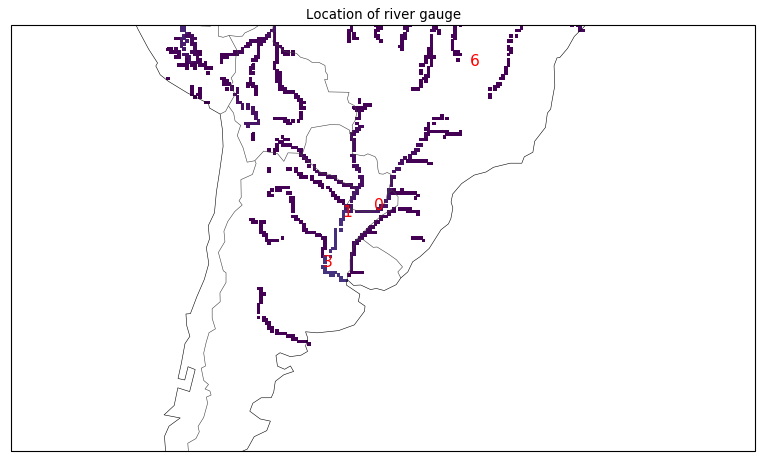

In [23]:
# # --- Filter by drainage area - should be atleast 10,000 km^2 --- #
# # --- Show location of GRDC stations for this subselection of stations --- #

# #Set up figure window
# fig=plt.figure(figsize=(12,8), dpi= 80, facecolor='w', edgecolor='k')

# #Set axes and color sections  
# ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

# #Set map extent based on river choice 
# if river=='MISSISSIPPI RIVER':
#     ax.set_extent([-100,-80,25,50])   
# elif river=='MEKONG':
#     ax.set_extent([85,115,5,30], crs=ccrs.PlateCarree())
# elif river=='NIGER':
#     ax.set_extent([-20,15,0,20], crs=ccrs.PlateCarree())
# elif river=='RIO PARANA':
#     ax.set_extent([-90,-20,-50,-10], crs=ccrs.PlateCarree())
# elif river=='VOLGA':
#     ax.set_extent([10,70,25,75], crs=ccrs.PlateCarree())
# elif river=='AMAZONAS':
#     ax.set_extent([-95,-30,-25,15], crs=ccrs.PlateCarree())
# elif river=='AMUR':
#     ax.set_extent([90,150,30,65], crs=ccrs.PlateCarree())
# elif river=='GANGES':
#     ax.set_extent([55,115,10,40], crs=ccrs.PlateCarree())
# elif river=='BRAHMAPUTRA':
#     ax.set_extent([55,115,10,40], crs=ccrs.PlateCarree())
# elif river=='DANUBE RIVER':
#     ax.set_extent([5,35,30,65], crs=ccrs.PlateCarree())
# elif river=='CONGO':
#     ax.set_extent([-10,45,-20,20], crs=ccrs.PlateCarree())
# elif river=='NILE':
#     ax.set_extent([0,60,-15,45], crs=ccrs.PlateCarree())
# elif river=='YANGTZE RIVER (CHANG JIANG)':
#     ax.set_extent([100,140,20,50], crs=ccrs.PlateCarree())
# elif river=='EUPHRATES':
#     ax.set_extent([25,55,15,55], crs=ccrs.PlateCarree())
# elif river=='TIGRIS':
#     ax.set_extent([25,55,15,55], crs=ccrs.PlateCarree())
# elif river=='LENA':
#     ax.set_extent([95,150,50,80], crs=ccrs.PlateCarree())
# elif river=='ZAMBEZI':
#     ax.set_extent([0,55,-30,-5], crs=ccrs.PlateCarree())
# elif river=='YENISEY':
#     ax.set_extent([65,110,45,80], crs=ccrs.PlateCarree())
# elif river=='HUANG HE (YELLOW RIVER)':
#     ax.set_extent([80,140,20,50], crs=ccrs.PlateCarree())
# elif river=='OB':
#     ax.set_extent([55,90,45,80], crs=ccrs.PlateCarree())
# elif river=='COLUMBIA RIVER':
#     ax.set_extent([-128,-115,42,53]) 
# elif river=='ORINOCO':
#     ax.set_extent([-75,-55,-5,20], crs=ccrs.PlateCarree())
# elif river=='TOCANTINS':
#     ax.set_extent([-60,-40,-15,5], crs=ccrs.PlateCarree())
# elif river=='YUKON RIVER':
#     ax.set_extent([-170,-130,55,75]) 
# elif river=='ST. LAWRENCE RIVER':
#     ax.set_extent([-80,-70,40,50]) 
# elif river=='FRASER RIVER':
#     ax.set_extent([-140,-110,45,65]) 
# elif river=='MACKENZIE RIVER':
#     ax.set_extent([-140,-110,55,80])
# elif river=='NELSON RIVER':
#     ax.set_extent([-115,-85,45,65])
# else:
#     ax.set_global()
    
# #Add figure title, coastlines, etc. 
# ax.set_title('Location of river gauge')
# ax.title.set_fontsize(12)
# ax.coastlines(linewidth=0.5,edgecolor='0.25')
# ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
# ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor='0.25')

# #Add location of GRDC station 
# # for iP in range(len(iVal[0][:])):
# #     ax.text(valLon[iP],valLat[iP],str(iP),color='red',fontsize=14)
# for iP in range(countVal):
#     if (areaGRDC[iP]>10000):
#         ax.text(lonGRDC[iP],latGRDC[iP],str(iP),color='red',fontsize=14)
    
# #Overlay CaMa discharge data 
# ax.pcolormesh(lon,lat,avgCtrlFlow,transform=ccrs.PlateCarree())



## Choose most upstream GRDC station (with nearby CaMa data) on selected river and compare to CaMa discharge within a 1/4 degree of that point
*So these are the GRDC stations most upstream with modeled discharge of at least [5000?] m^3/s.*

In [24]:
# # --- Define upstream grid point and get all data from there --- # 
# iUp    = 3                 #Index of station chosen (from above map)

# upFlow = flowGRDC[iUp,:]   #Streamflow (daily) at upstream point
# upErr  = errGRDC[iUp,:]    #StdErr on daily streamflow at upstream point
# upLon  = lonGRDC[iUp]      #Longitude of upstream point
# upLat  = latGRDC[iUp]      #Latitude of upstream point


In [25]:
# # --- Average CaMa discharge near this GRDC station --- #

# avgDist = 0.25   #Average together all gridcells in +/- this distance (given in degrees)

# ilon = np.where((lon>(upLon-avgDist)) & (lon<(upLon+avgDist)))
# ilat = np.where((lat>(upLat-avgDist)) & (lat<(upLat+avgDist)))

# #Isolate region in each experiment and average over that domain 
# ctrl_region    = globalVarCtrl[ilat[0][:],:,:]
# ctrl_region    = ctrl_region[:,ilon[0][:],:]
# avgCtrl_region = np.nanmean(np.nanmean(ctrl_region,axis=0),axis=0)

# full_region    = globalVarFull[ilat[0][:],:,:]
# full_region    = full_region[:,ilon[0][:],:]
# avgFull_region = np.nanmean(np.nanmean(full_region,axis=0),axis=0)

# phys_region    = globalVarPhys[ilat[0][:],:,:]
# phys_region    = phys_region[:,ilon[0][:],:]
# avgPhys_region = np.nanmean(np.nanmean(phys_region,axis=0),axis=0)

# rad_region    = globalVarRad[ilat[0][:],:,:]
# rad_region    = rad_region[:,ilon[0][:],:]
# avgRad_region = np.nanmean(np.nanmean(rad_region,axis=0),axis=0)

# #Take same averaging approach for standard error (is this the right way to go??)
# ctrl_err      = globalErrCtrl[ilat[0][:],:,:]
# ctrl_err      = ctrl_err[:,ilon[0][:],:]
# errCtrl_region = np.nanmean(np.nanmean(ctrl_err,axis=0),axis=0)

# full_err      = globalErrFull[ilat[0][:],:,:]
# full_err      = full_err[:,ilon[0][:],:]
# errFull_region = np.nanmean(np.nanmean(full_err,axis=0),axis=0)

# phys_err      = globalErrPhys[ilat[0][:],:,:]
# phys_err      = phys_err[:,ilon[0][:],:]
# errPhys_region = np.nanmean(np.nanmean(phys_err,axis=0),axis=0)

# rad_err       = globalErrRad[ilat[0][:],:,:]
# rad_err       = rad_err[:,ilon[0][:],:]
# errRad_region = np.nanmean(np.nanmean(rad_err,axis=0),axis=0)


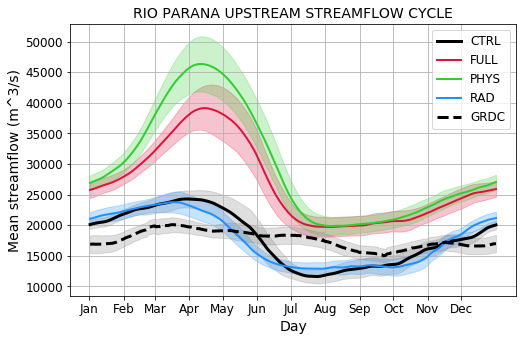

In [26]:
# # --- Compre streamflow annual average cycles ---- #

# #Define figure window 
# fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
# my_fontsize = 14

# ## --- Set axes and size sections --- 
# plt.plot(days,avgCtrl_region,color ='Black',label='CTRL',linewidth=3)
# plt.plot(days,avgFull_region,color ='Crimson',label='FULL',linewidth=2)
# plt.plot(days,avgPhys_region,color = 'LimeGreen',label='PHYS',linewidth=2)
# plt.plot(days,avgRad_region,color='DodgerBlue',label='RAD',linewidth=2)
# plt.plot(days,upFlow,linestyle='dashed',color ='Black',label='GRDC',linewidth=3)
# #Add error "bars"
# plt.fill_between(days,avgCtrl_region-(2*errCtrl_region),avgCtrl_region+(2*errCtrl_region),alpha=0.25,color='Grey')
# plt.fill_between(days,avgFull_region-(2*errFull_region),avgFull_region+(2*errFull_region),alpha=0.25,color='Crimson')
# plt.fill_between(days,avgPhys_region-(2*errPhys_region),avgPhys_region+(2*errPhys_region),alpha=0.25,color='LimeGreen')
# plt.fill_between(days,avgRad_region-(2*errRad_region),avgRad_region+(2*errRad_region),alpha=0.25,color='DodgerBlue')
# plt.fill_between(days,upFlow-(2*upErr),upFlow+(2*upErr),alpha=0.25,color='Grey')

# plt.legend(fontsize=12)
# plt.title(river+ ' UPSTREAM STREAMFLOW CYCLE',fontsize=my_fontsize)
# plt.xlabel('Day',fontsize=my_fontsize)
# plt.ylabel('Mean streamflow (m^3/s)',fontsize=my_fontsize)
# plt.grid()
# plt.xticks(startMon,months)
# plt.tick_params(axis='both',labelsize=12)




## Create figure for manuscript (requires running each basin separately above and saving data in individual cells here)

In [51]:
#Amazon 
amazonCtrl = avgCtrl_region
amazonFull = avgFull_region
amazonPhys = avgPhys_region
amazonRad  = avgRad_region
amazonGRDC = upFlow
amazonCtrlErr = errCtrl_region
amazonFullErr = errFull_region
amazonPhysErr = errPhys_region
amazonRadErr  = errRad_region
amazonGRDCerr = upErr


In [62]:
#Parana
paranaCtrl = avgCtrl_region
paranaFull = avgFull_region
paranaPhys = avgPhys_region
paranaRad  = avgRad_region
paranaGRDC = upFlow
paranaCtrlErr = errCtrl_region
paranaFullErr = errFull_region
paranaPhysErr = errPhys_region
paranaRadErr  = errRad_region
paranaGRDCerr = upErr


In [70]:
#Congo
congoCtrl = avgCtrl_region
congoFull = avgFull_region
congoPhys = avgPhys_region
congoRad  = avgRad_region
congoGRDC = upFlow
congoCtrlErr = errCtrl_region
congoFullErr = errFull_region
congoPhysErr = errPhys_region
congoRadErr  = errRad_region
congoGRDCerr = upErr


In [78]:
#Yangtze
yangtzeCtrl = avgCtrl_region
yangtzeFull = avgFull_region
yangtzePhys = avgPhys_region
yangtzeRad  = avgRad_region
yangtzeGRDC = upFlow
yangtzeCtrlErr = errCtrl_region
yangtzeFullErr = errFull_region
yangtzePhysErr = errPhys_region
yangtzeRadErr  = errRad_region
yangtzeGRDCerr = upErr



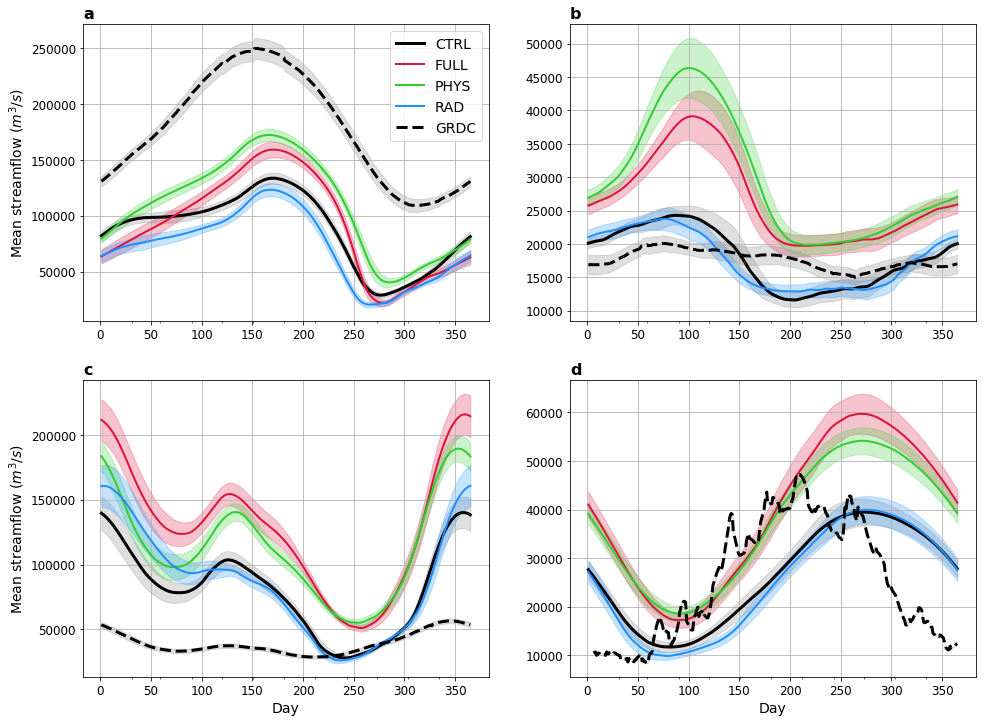

In [79]:
# --- PLOT --- #


## --- Set up figure window --- 
fig, ax_array = plt.subplots(2,2)
ax1,ax2,ax3,ax4 = ax_array.flatten()
fig.set_size_inches(16,12)

fig.subplots_adjust(wspace=0.1, hspace=0.2)

#Set up axes 
ax1.set_title('a',{'fontweight' :'bold','fontsize':16},loc='left') 
ax2.set_title('b',{'fontweight' :'bold','fontsize':16},loc='left') 
ax3.set_title('c',{'fontweight' :'bold','fontsize':16},loc='left') 
ax4.set_title('d',{'fontweight' :'bold','fontsize':16},loc='left') 


ax3.set_xlabel('Day',fontsize=my_fontsize)
ax4.set_xlabel('Day',fontsize=my_fontsize)
ax1.set_ylabel('Mean streamflow '+ r'$(m^3/s)$',fontsize=my_fontsize)
ax3.set_ylabel('Mean streamflow '+ r'$(m^3/s)$',fontsize=my_fontsize)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.set_xticks(startMon,months)
ax2.set_xticks(startMon,months)
ax3.set_xticks(startMon,months)
ax4.set_xticks(startMon,months)
ax1.tick_params(axis='both',labelsize=12)
ax2.tick_params(axis='both',labelsize=12)
ax3.tick_params(axis='both',labelsize=12)
ax4.tick_params(axis='both',labelsize=12)


# PLOT AMAZON #
ax1.plot(days,amazonCtrl,color ='Black',label='CTRL',linewidth=3)
ax1.plot(days,amazonFull,color ='Crimson',label='FULL',linewidth=2)
ax1.plot(days,amazonPhys,color = 'LimeGreen',label='PHYS',linewidth=2)
ax1.plot(days,amazonRad,color='DodgerBlue',label='RAD',linewidth=2)
ax1.plot(days,amazonGRDC,linestyle='dashed',color ='Black',label='GRDC',linewidth=3)
#Add error "bars"
ax1.fill_between(days,amazonCtrl-(2*amazonCtrlErr),amazonCtrl+(2*amazonCtrlErr),alpha=0.25,color='Grey')
ax1.fill_between(days,amazonFull-(2*amazonFullErr),amazonFull+(2*amazonFullErr),alpha=0.25,color='Crimson')
ax1.fill_between(days,amazonPhys-(2*amazonPhysErr),amazonPhys+(2*amazonPhysErr),alpha=0.25,color='LimeGreen')
ax1.fill_between(days,amazonRad-(2*amazonRadErr),amazonRad+(2*amazonRadErr),alpha=0.25,color='DodgerBlue')
ax1.fill_between(days,amazonGRDC-(2*amazonGRDCerr),amazonGRDC+(2*amazonGRDCerr),alpha=0.25,color='Grey')
#Legend
ax1.legend(fontsize=14)
# ------------------------------------


# PLOT PARANA # 
ax2.plot(days,paranaCtrl,color ='Black',label='CTRL',linewidth=3)
ax2.plot(days,paranaFull,color ='Crimson',label='FULL',linewidth=2)
ax2.plot(days,paranaPhys,color = 'LimeGreen',label='PHYS',linewidth=2)
ax2.plot(days,paranaRad,color='DodgerBlue',label='RAD',linewidth=2)
ax2.plot(days,paranaGRDC,linestyle='dashed',color ='Black',label='GRDC',linewidth=3)
#Add error "bars"
ax2.fill_between(days,paranaCtrl-(2*paranaCtrlErr),paranaCtrl+(2*paranaCtrlErr),alpha=0.25,color='Grey')
ax2.fill_between(days,paranaFull-(2*paranaFullErr),paranaFull+(2*paranaFullErr),alpha=0.25,color='Crimson')
ax2.fill_between(days,paranaPhys-(2*paranaPhysErr),paranaPhys+(2*paranaPhysErr),alpha=0.25,color='LimeGreen')
ax2.fill_between(days,paranaRad-(2*paranaRadErr),paranaRad+(2*paranaRadErr),alpha=0.25,color='DodgerBlue')
ax2.fill_between(days,paranaGRDC-(2*paranaGRDCerr),paranaGRDC+(2*paranaGRDCerr),alpha=0.25,color='Grey')
# ------------------------------------

# PLOT CONGO #
ax3.plot(days,congoCtrl,color ='Black',label='CTRL',linewidth=3)
ax3.plot(days,congoFull,color ='Crimson',label='FULL',linewidth=2)
ax3.plot(days,congoPhys,color = 'LimeGreen',label='PHYS',linewidth=2)
ax3.plot(days,congoRad,color='DodgerBlue',label='RAD',linewidth=2)
ax3.plot(days,congoGRDC,linestyle='dashed',color ='Black',label='GRDC',linewidth=3)
#Add error "bars"
ax3.fill_between(days,congoCtrl-(2*congoCtrlErr),congoCtrl+(2*congoCtrlErr),alpha=0.25,color='Grey')
ax3.fill_between(days,congoFull-(2*congoFullErr),congoFull+(2*congoFullErr),alpha=0.25,color='Crimson')
ax3.fill_between(days,congoPhys-(2*congoPhysErr),congoPhys+(2*congoPhysErr),alpha=0.25,color='LimeGreen')
ax3.fill_between(days,congoRad-(2*congoRadErr),congoRad+(2*congoRadErr),alpha=0.25,color='DodgerBlue')
ax3.fill_between(days,congoGRDC-(2*congoGRDCerr),congoGRDC+(2*congoGRDCerr),alpha=0.25,color='Grey')
# ------------------------------------

# PLOT YANGTZE #
ax4.plot(days,yangtzeCtrl,color ='Black',label='CTRL',linewidth=3)
ax4.plot(days,yangtzeFull,color ='Crimson',label='FULL',linewidth=2)
ax4.plot(days,yangtzePhys,color = 'LimeGreen',label='PHYS',linewidth=2)
ax4.plot(days,yangtzeRad,color='DodgerBlue',label='RAD',linewidth=2)
ax4.plot(days,yangtzeGRDC,linestyle='dashed',color ='Black',label='GRDC',linewidth=3)
#Add error "bars"
ax4.fill_between(days,yangtzeCtrl-(2*yangtzeCtrlErr),yangtzeCtrl+(2*yangtzeCtrlErr),alpha=0.25,color='Grey')
ax4.fill_between(days,yangtzeFull-(2*yangtzeFullErr),yangtzeFull+(2*yangtzeFullErr),alpha=0.25,color='Crimson')
ax4.fill_between(days,yangtzePhys-(2*yangtzePhysErr),yangtzePhys+(2*yangtzePhysErr),alpha=0.25,color='LimeGreen')
ax4.fill_between(days,yangtzeRad-(2*yangtzeRadErr),yangtzeRad+(2*yangtzeRadErr),alpha=0.25,color='DodgerBlue')
ax4.fill_between(days,yangtzeGRDC-(2*yangtzeGRDCerr),yangtzeGRDC+(2*yangtzeGRDCerr),alpha=0.25,color='Grey')
# ------------------------------------


fig.subplots_adjust(wspace=0.2, hspace=0.2)

#fig.savefig('Figure_StreamflowCycles.pdf',bbox_inches = 'tight')  #Save figure as pdf




## Scratchwork

In [26]:
#GRDC data isn't matching up at all stations to what I had before... 
fileNew = '/gdata/pritchard2/mdfowler/GRDC-data/new_Sep2018/4127800_Q_Day.Cmd.txt'

minYr = 1970
maxYr = 2005

flowGRDCNew = np.full([365],np.nan)
errGRDCNew  = np.full([365],np.nan)

dataNew = pd.read_csv(fileNew, sep=";", header=40,names=['Date','HH:MM','Value'])   
dataNew['Date'] = dataNew['Date'].str.split('-')

#Save year and month from dataframe
yearNew  = np.full([len(dataNew['Date'])],np.nan)
monthNew = np.full([len(dataNew['Date'])],np.nan)
dayNew   = np.full([len(dataNew['Date'])],np.nan)

for it in range(len(dataNew['Date'])):
    yearNew[it]  = np.asarray(dataNew['Date'][it][0],dtype=int)
    monthNew[it] = np.asarray(dataNew['Date'][it][1],dtype=int)
    dayNew[it]   = np.asarray(dataNew['Date'][it][2],dtype=int)

#Limit data to period of interest
iVal = np.where((yearNew>=minYr) & (yearNew<=maxYr))
valueSelNew = dataNew.Value.values[iVal]
monSelNew   = monthNew[iVal]
daySelNew   = dayNew[iVal]
#Eliminate missing data and replace with NaNs
valueSelNew[np.where(valueSelNew==-999.0)]=np.nan

# --- Compute annual climatology --- #
#Define julian day counter for indexing 
dayCount = 0 
#Loop over months and days 
for iMon in range(12):
    for iDay in range(daysPerMonth[iMon]):
        #Find all dates of a certain month-day in the selected years 
        valDays = np.where((monSelNew==iMon+1) & (daySelNew==iDay+1))
        #Define average flow on this day 
        flowGRDCNew[dayCount] = np.nanmean(valueSelNew[valDays])
        #Define standard error 
        errGRDCNew[dayCount] = np.nanstd(valueSelNew[valDays])/np.sqrt(len(valueSelNew[valDays]))                
        #Increment day of year tracker
        dayCount=dayCount+1  
                




In [30]:
#Old data
fileOld = '/gdata/pritchard2/mdfowler/GRDC-data/4127800.day'

origAnnAvg_allBasin = np.full([365],np.nan)
calcAnnAvg_allBasin = np.full([365],np.nan)
errOrig_allBasin    = np.full([365],np.nan)
errCalc_allBasin    = np.full([365],np.nan)

#Read in GRDC data using pandas 
data = pd.read_csv(fileOld, sep=";", header=40,names=['Date','HH:MM','Original','Calculated','Flag'])
data['Date'] = data['Date'].str.split('-')

#Save year and month from dataframe
year  = np.full([len(data['Date'])],np.nan)
month = np.full([len(data['Date'])],np.nan)
day   = np.full([len(data['Date'])],np.nan)

for it in range(len(data['Date'])):
    year[it]  = np.asarray(data['Date'][it][0],dtype=int)
    month[it] = np.asarray(data['Date'][it][1],dtype=int)
    day[it]   = np.asarray(data['Date'][it][2],dtype=int)

#Limit data to period of interest
iVal = np.where((year>=minYr) & (year<=maxYr))
origSel = data.Original.values[iVal]
calcSel = data.Calculated.values[iVal]
monSel  = month[iVal]
daySel  = day[iVal]
print('iVal shape: ',np.shape(iVal))
print('calc chape: ',np.shape(calcSel))
    
# --- Compute annual climatology --- #

#Define julian day counter for indexing 
dayCount = 0 

#Loop over months and days 
for iMon in range(12):
    for iDay in range(daysPerMonth[iMon]):
        #Find all dates of a certain month-day in the selected years 
        valDays = np.where((monSel==iMon+1) & (daySel==iDay+1))

        #Define average flow on this day 
        origAnnAvg_allBasin[dayCount] = np.nanmean(origSel[valDays])
        calcAnnAvg_allBasin[dayCount] = np.nanmean(calcSel[valDays])

        #Define standard error 
        errOrig_allBasin[dayCount] = np.nanstd(origSel[valDays])/np.sqrt(len(origSel[valDays]))                
        errCalc_allBasin[dayCount] = np.nanstd(calcSel[valDays])/np.sqrt(len(calcSel[valDays]))

        dayCount=dayCount+1





iVal shape:  (1, 13149)
calc chape:  (13149,)


18653.585994818535

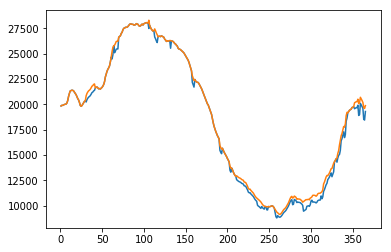

In [35]:
plt.plot(days,calcAnnAvg_allBasin)
plt.plot(days,flowGRDCNew)
np.nanmean(flowGRDCNew)

In [ ]:
# # --- Plot all available GRDC stations to choose 'upstream' --- # 

# #Show location of GRDC station 
# fig=plt.figure(figsize=(8,4), dpi= 80, facecolor='w', edgecolor='k')

# ## --- Set axes and color sections --- 
# ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

# #Set map extent based on river choice 
# if river=='MISSISSIPPI RIVER':
#     ax.set_extent([-100,-80,25,50])   
# elif river=='MEKONG':
#     ax.set_extent([80,130,0,35], crs=ccrs.PlateCarree())
    
# #Add figure title, coastlines, etc. 
# ax.set_title('Location of river gauge')
# ax.title.set_fontsize(12)
# ax.coastlines(linewidth=0.5,edgecolor='0.25')
# ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
# ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor='0.25')
# #Add dot for GRDC station 
# for iP in range(len(lonGRDC)):
#     ax.text(lonGRDC[iP],latGRDC[iP],str(iP),color='red',fontsize=14)
